In [1]:
#pip install quantecon

In [3]:
import numpy as np
import math
from scipy.optimize import fsolve
from quantecon.markov.approximation import tauchen
import matplotlib.pyplot as plt
from scipy import interpolate

In [4]:
# Define parameter values
θ = .21
ν = .64
δ = .1
β = .96
φ = .5
ρ = .9
σ = .02
N_rep = .6   # assume steady state labor supply from rep. household
tol = 1e-6
ϵ = tauchen(ρ,σ,0,3,10)

In [81]:
'''
------------------------------------------------------------------------
Steady state functions
------------------------------------------------------------------------
'''

# Firm labor demand given w and k
n_star = lambda ν,θ,ϵ,w,k: (k>0)*(w/(math.exp(ϵ)*ν*k**θ))**(1/(ν-1))
# Derivative of firm profit wrt k
π_k = lambda ν,θ,ϵ,w,k: θ*math.exp(ϵ)*k**(θ-1)*n_star(ν,θ,ϵ,w,k)**ν
# Derivative of value function V wrt k
V_k = lambda ν,θ,δ,φ,ϵ,w,k: π_k(ν,θ,ϵ,w,k) - φ/2*δ**2-(φ+1)*δ+1

# Left hand side of firm FOC
def foc(k,w,parameters):
    β,ν,θ,δ,φ,ϵ = parameters
    foc_lhs = -1-φ*δ + β*V_k(ν,θ,δ,φ,ϵ,w,k)
    return foc_lhs

# Solve for steady state capital given w
def get_Kss(w,parameters):
    kss = fsolve(foc,.1,args=(w,parameters))
    return kss

# Solve the steady state capital and w
def excess_labor_supply(w,parameters):
    β,ν,θ,δ,φ,N_rep = parameters
    k = get_Kss(w,[β,ν,θ,δ,φ,0])
    n = n_star(ν,θ,0,w,k)
    n_excess = N_rep - n
    return n_excess


# Value function iteration
def VFI(cf,w,k_grid,parameters,ϵ):
    ν,θ,δ,φ,tol = parameters
    π = lambda ν,θ,ϵ,w,k: math.exp(ϵ)*k**θ*n_star(ν,θ,ϵ,w,k)**ν-w*n_star(ν,θ,ϵ,w,k)
    
    nϵ,nk = len(ϵ.state_values),len(k_grid)
    V = np.zeros((nϵ*nk,1))
    max_diff = np.inf
    niter = 1
    
    while max_diff > tol:
        ev = np.zeros((nϵ*nk,1))
        for iϵ in range(nϵ):
            for ik in range(nk):
                idx = iϵ*nk + ik 
                idxp = np.arange(ik,nϵ*nk+ik,nk)
                ev[idx] = ev[idx] + ϵ.P[iϵ,:].dot(V[idxp])
                
        tempV, gk = (1-δ)*np.ones((nϵ,1)).dot(k_grid.T).reshape(nϵ*nk,1), np.zeros((nϵ*nk,1))        
        for iϵ,ϵ_curr in enumerate(ϵ.state_values):
            for ik,k in enumerate(k_grid):
                idx = iϵ*nk + ik 
                
                vv = (1-δ)*k
                for ikp,kp in enumerate(k_grid):
                    idxp = iϵ*nk + ikp
                    investment = kp - (1-δ)*k
                    v_temp = π(ν,θ,ϵ_curr,w,k) - investment - φ/2*(investment/k)**2 -cf + β*ev[idxp]
                    
                    if v_temp > vv:
                        vv = v_temp
                        tempV[idx] = v_temp
                        gk[idx] = kp
                        
        max_diff = max(np.abs(V-tempV))
        V = tempV
        if niter == 1 or niter % 10 == 0:
            print('Iteration %d: max diff = %1.7f' % (niter,max_diff))
                  
        niter = niter + 1
    return V,gk

def euler_lhs(k,kp,kpp,w,ν,θ,β,φ,δ,ϵ,iϵ):
    if k != 0 and kp != 0:
        lhs = -1 -φ*(kp/k-(1-δ)) + β * sum([b*(π_k(ν,θ,a,w,kp)+(1-δ)- (kp>0)*φ/2*((kpp/kp-(1-δ))**2-2*kpp/kp*(kpp/kp-(1-δ)))) \
         for a,b in zip(ϵ.state_values, ϵ.P[iϵ,:]) ])
    elif k == 0 and kp != 0:
        lhs = -1 + β * sum([b*(π_k(ν,θ,a,w,kp)+(1-δ)- (kp>0)*φ/2*((kpp/kp-(1-δ))**2-2*kpp/kp*(kpp/kp-(1-δ)))) \
         for a,b in zip(ϵ.state_values, ϵ.P[iϵ,:]) ])
    elif k != 0 and kp == 0:
        lhs = -1 -φ*(kp/k-(1-δ))
    else:
        lhs = 0
    
    return lhs
                

# Endogenous grid method for incumbent firm's decision rules
def EGM(cf,w,k_grid,parameters,ϵ):
    ν,θ,δ,φ,tol = parameters
    π = lambda ν,θ,ϵ,w,k: math.exp(ϵ)*k**θ*n_star(ν,θ,ϵ,w,k)**ν-w*n_star(ν,θ,ϵ,w,k)
    π_k = lambda ν,θ,ϵ,w,k: θ*math.exp(ϵ)*k**(θ-1)*n_star(ν,θ,ϵ,w,k)**ν
    
    nϵ,nk = len(ϵ.state_values),len(k_grid)
    k_end, k1_end, k2_end = np.zeros((nϵ*nk,1)), np.zeros((nϵ*nk,1)), np.zeros((nϵ*nk,1))
#     euler1_lhs = lambda k,kp,β,φ,δ: -1-φ*(kp/k-(1-δ))+β*(1-δ)
#     euler2_lhs = lambda k,kp,kpp,w,ν,θ,β,φ,δ,ϵ,iϵ: -1-(k>0)*φ*(kp/k-(1-δ))+β* \
#     sum([b*(π_k(ν,θ,a,w,kp)+1-δ- (kp>0)*φ/2*((kpp/kp-(1-δ))**2-2*kpp/kp*(kpp/kp-(1-δ)))) \
#          for a,b in zip(ϵ.state_values, ϵ.P[iϵ,:]) ])
    
#     # Create choice-specific endogenous grid for k
#     for iϵ in range(nϵ):
#         for ikp,kp in enumerate(k_grid):
#             idx = iϵ*nk + ikp 
#             k1_end[idx] = fsolve(euler1_lhs,.1,args=(kp,β,φ,δ))
#             k2_end[idx] = fsolve(euler2_lhs,.1,args=(kp,w,ν,θ,β,φ,δ,ϵ,iϵ))
    
    max_diff = np.inf
    niter = 1
    
    # Guess value functions
    V_e = (1-δ)*np.ones((nϵ,1)).dot(k_grid.T).reshape(nϵ*nk,1)
    V_tilde = V_e + np.ones((nϵ,1)).dot(np.linspace(-.1,.1,nk).reshape(1,nk)).reshape(nϵ*nk,1)
    V = np.maximum(V_tilde-cf,V_e)

    # Guess a policy function of k' defined on the original grid
    gk = np.ones((nϵ,1)).dot(k_grid.T).reshape(nϵ*nk,1)
    
    while max_diff > tol:

        ev = np.zeros((nϵ*nk,1))
        for iϵ in range(nϵ):
            for ik in range(nk):
                idx = iϵ*nk + ik 
                idxp = np.arange(ik,nϵ*nk+ik,nk)
                ev[idx] = ev[idx] + ϵ.P[iϵ,:].dot(V[idxp])
                        
#         k_end = k1_end * (V_tilde - cf < V_e) + k2_end *(V_tilde - cf >= V_e)
#         V_tilde_end,V_tilde_new = np.zeros((nϵ*nk,1)),np.zeros((nϵ*nk,1))
        k_end,V_tilde_end,V_tilde_new = np.zeros((nϵ*nk,1)),np.zeros((nϵ*nk,1)),np.zeros((nϵ*nk,1))
        
        for iϵ, ϵ_curr in enumerate(ϵ.state_values):
            grid_range = np.arange(iϵ*nk,iϵ*nk+nk,1)
            ev_interp = interpolate.interp1d(k_grid.reshape(nk,),ev[grid_range].reshape(nk,),fill_value='extrapolate')
            
            # Iterate over k'
            ik_cutoff = -np.inf
            for ikp,kp in enumerate(k_grid):
                idxp = iϵ*nk + ikp 
                kpp = gk[idxp]
                k = max(fsolve(euler_lhs,.1,args=(kp,kpp,w,ν,θ,β,φ,δ,ϵ,iϵ)),0)
                k_end[idxp] = k
#                 k = k_end[idx] 
                if k != 0:
                    V_tilde_end[idxp] = π(ν,θ,ϵ_curr,w,k) - (kp-(1-δ)*k) - φ/2*(kp/k-(1-δ))**2 *k + β*ev_interp(k)
                else:
                    V_tilde_end[idxp] = - (kp-(1-δ)*k) + β*ev_interp(k)
                    
                if V_tilde_end[idxp] - cf < (1-δ)*k:
                    ik_cutoff = ikp
                        
            V_tilde_end_interp = interpolate.interp1d(k_end[grid_range].reshape(nk,),V_tilde_end[grid_range].reshape(nk,),fill_value='extrapolate')
            grid_range = np.arange(iϵ*nk+ik_cutoff+1,iϵ*nk+nk,1)
            gk_interp = interpolate.interp1d(k_end[grid_range].reshape(nk-ik_cutoff-1,),k_grid[ik_cutoff+1:].reshape(nk-ik_cutoff-1,),fill_value='extrapolate')
            for ik,k in enumerate(k_grid):
                idx = iϵ*nk + ik                
                V_tilde_new[idx] = V_tilde_end_interp(k)
#                 if np.isnan(V_tilde_new[idx]):
#                     V_tilde_new[idx] = -np.inf
                if ik <= ik_cutoff:
                    gk[idx] = 0                    
                else:
                    gk[idx] = gk_interp(k)                        
        
        V_new = np.maximum(V_tilde_new-cf,V_e)
        max_diff = max(np.abs(V_new-V))
        V = V_new.copy()
        if niter == 1 or niter % 1 == 0:
            print('Iteration %d: max diff = %1.7f' % (niter,max_diff))
                  
        niter = niter + 1
        if niter == 4:
            plt.plot(gk)
    return V,gk

In [6]:
# Solve for representative agent steady state
w = 1
parameters = [β,ν,θ,δ,φ,N_rep]
wss = fsolve(excess_labor_supply,.25,args=parameters)
kss = get_Kss(w,[β,ν,θ,δ,φ,0])

k_grid = np.linspace(0,5*kss,50)
parameters = [ν,θ,δ,φ,tol]

In [208]:
# Solve for incumbent firm's decision rules
cf = .01
V,kp = VFI(cf,w,k_grid,parameters,ϵ)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide


Iteration 1: max diff = 1.8738515
Iteration 10: max diff = 0.0388894
Iteration 20: max diff = 0.0171801
Iteration 30: max diff = 0.0097648
Iteration 40: max diff = 0.0061470
Iteration 50: max diff = 0.0040021
Iteration 60: max diff = 0.0026393
Iteration 70: max diff = 0.0017493
Iteration 80: max diff = 0.0011616
Iteration 90: max diff = 0.0007719
Iteration 100: max diff = 0.0005131
Iteration 110: max diff = 0.0003411
Iteration 120: max diff = 0.0002268
Iteration 130: max diff = 0.0001508
Iteration 140: max diff = 0.0001002
Iteration 150: max diff = 0.0000666
Iteration 160: max diff = 0.0000443
Iteration 170: max diff = 0.0000295
Iteration 180: max diff = 0.0000196
Iteration 190: max diff = 0.0000130
Iteration 200: max diff = 0.0000087
Iteration 210: max diff = 0.0000058
Iteration 220: max diff = 0.0000038
Iteration 230: max diff = 0.0000025
Iteration 240: max diff = 0.0000017
Iteration 250: max diff = 0.0000011


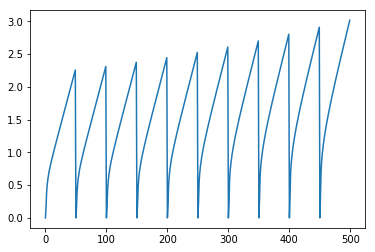

In [209]:
plt.plot(V)

Iteration 1: max diff = 0.0680746
Iteration 2: max diff = 0.0780506
Iteration 3: max diff = 0.1554312
Iteration 4: max diff = 0.2541947
Iteration 5: max diff = 0.5146671
Iteration 6: max diff = 0.1974712


KeyboardInterrupt: 

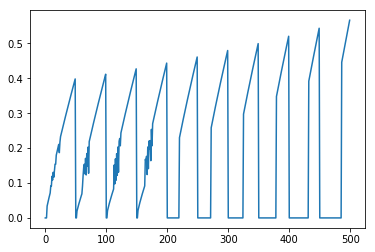

In [82]:
cf = .01
parameters = ν,θ,δ,φ,tol
aa = EGM(cf,w,k_grid,parameters,ϵ)
